# Genel

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


warnings.filterwarnings("ignore")

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
df = pd.read_csv("hotel_bookings 2.csv")

In [5]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/7/2015


In [6]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [8]:
df.isnull().sum().sort_values(ascending=False)


company                           112593
agent                              16340
country                              488
children                               4
arrival_date_month                     0
arrival_date_week_number               0
hotel                                  0
is_canceled                            0
stays_in_weekend_nights                0
arrival_date_day_of_month              0
adults                                 0
stays_in_week_nights                   0
babies                                 0
meal                                   0
lead_time                              0
arrival_date_year                      0
distribution_channel                   0
market_segment                         0
previous_bookings_not_canceled         0
is_repeated_guest                      0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
previous_cancellations                 0
deposit_type    

In [9]:
# 'company' ve 'agent' sütunlarındaki eksik değerler, bir acente veya şirketle çalışılmadığı anlamına gelebilir.
# Bu nedenle bunları 0 ile dolduruyoruz. 'country' için en sık tekrar eden değeri (mod) kullanabiliriz.
# 'children' sütunundaki birkaç eksik değeri 0 ile doldurmak mantıklıdır.
df["company"].fillna(0, inplace=True)
df["agent"].fillna(0, inplace=True)
df["country"].fillna(df["country"].mode()[0], inplace=True)
df["children"].fillna(0, inplace=True)

In [10]:
# 'adr' (ortalama günlük fiyat) 0 olan ve misafir sayısı 0 olan anlamsız kayıtları temizleyelim.
# Bu durumlar genellikle hatalı veri girişidir.
df = df[df["adr"] > 0]
df = df[(df["adults"] + df["children"] + df["babies"]) > 0]

In [11]:
# Genel İptal Oranı
cancellation_rate = df['is_canceled'].value_counts(normalize=True) * 100
print(f"\nGenel İptal Oranı:\n{cancellation_rate}")


Genel İptal Oranı:
is_canceled
0    62.511606
1    37.488394
Name: proportion, dtype: float64


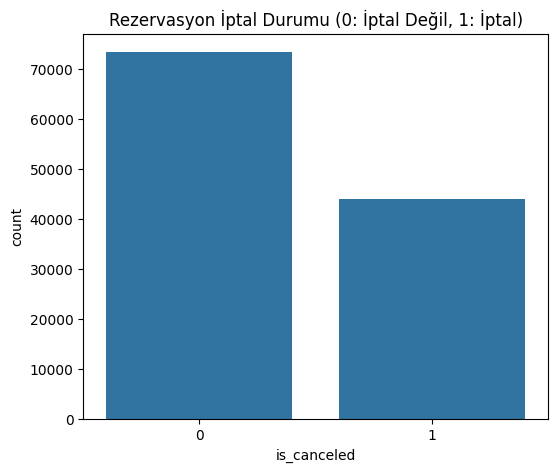

In [12]:
plt.figure(figsize=(6, 5))
sns.countplot(x='is_canceled', data=df)
plt.title('Rezervasyon İptal Durumu (0: İptal Değil, 1: İptal)')
plt.show()

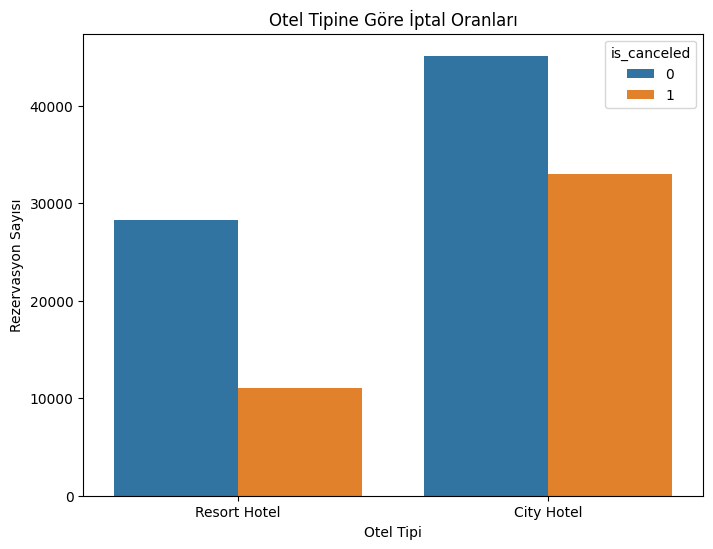

In [13]:
# Otel Tipine Göre İptal Oranları
plt.figure(figsize=(8, 6))
sns.countplot(x='hotel', hue='is_canceled', data=df)
plt.title('Otel Tipine Göre İptal Oranları')
plt.xlabel('Otel Tipi')
plt.ylabel('Rezervasyon Sayısı')
plt.show()

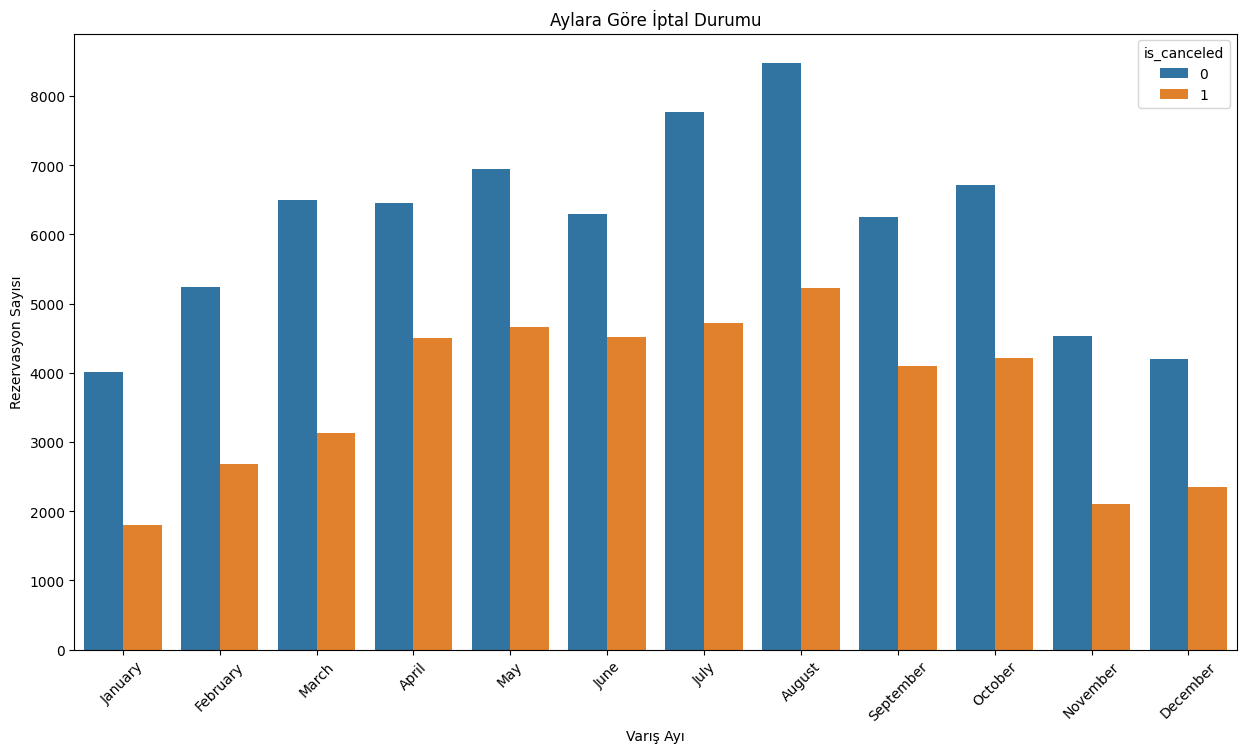

In [14]:
# Aylara Göre İptal Oranları
ay_siralama = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], categories=ay_siralama, ordered=True)

plt.figure(figsize=(15, 8))
sns.countplot(x='arrival_date_month', hue='is_canceled', data=df)
plt.title('Aylara Göre İptal Durumu')
plt.xlabel('Varış Ayı')
plt.xticks(rotation=45)
plt.ylabel('Rezervasyon Sayısı')
plt.show()

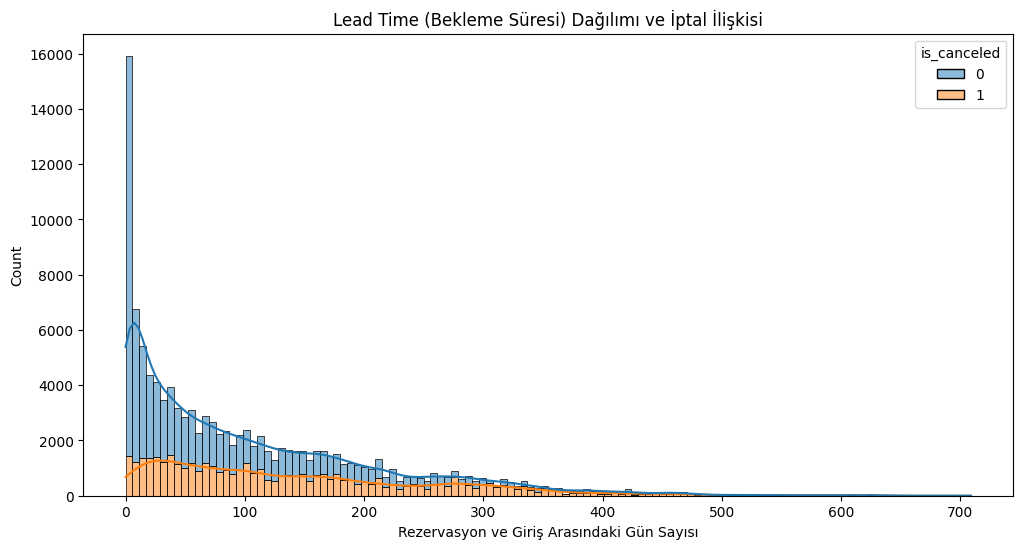

In [15]:
# Lead Time'ın İptale Etkisi
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='lead_time', hue='is_canceled', kde=True, multiple="stack")
plt.title('Lead Time (Bekleme Süresi) Dağılımı ve İptal İlişkisi')
plt.xlabel('Rezervasyon ve Giriş Arasındaki Gün Sayısı')
plt.show()

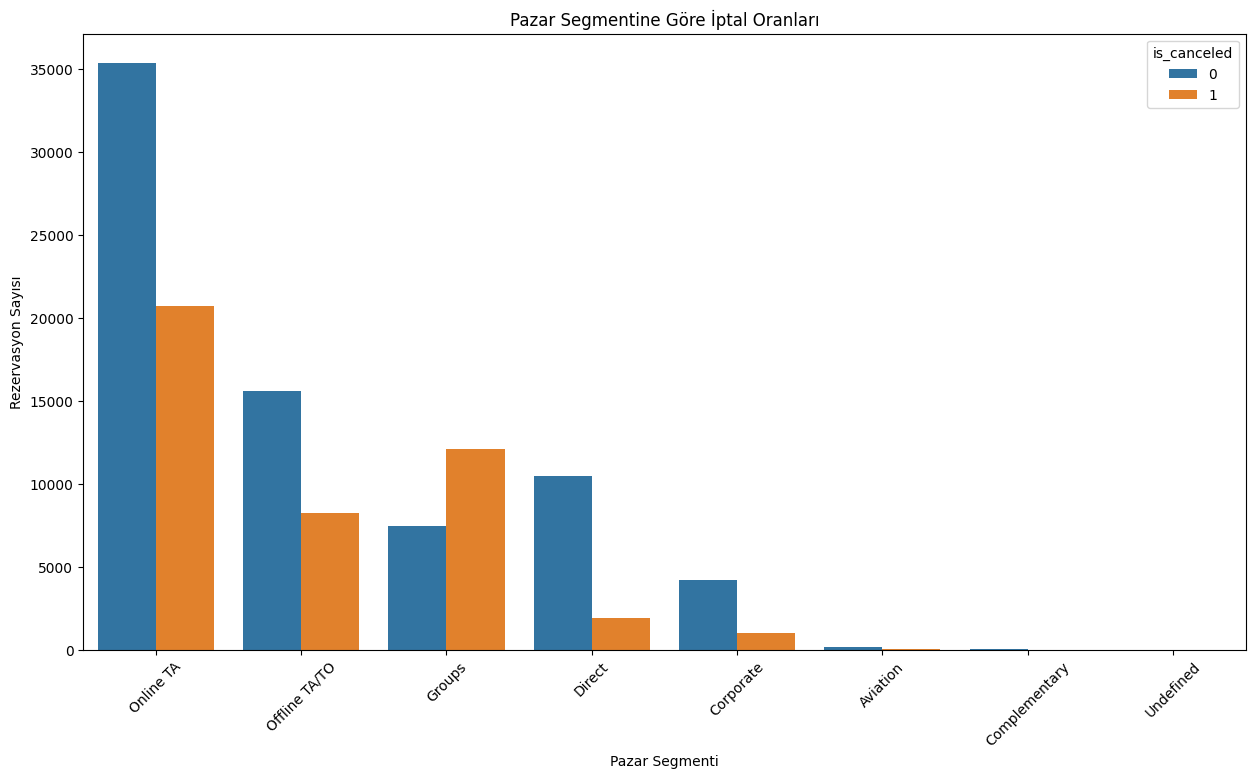

In [16]:
# Pazar Segmentinin (Market Segment) Etkisi
plt.figure(figsize=(15, 8))
sns.countplot(x='market_segment', data=df, hue='is_canceled', order=df['market_segment'].value_counts().index)
plt.title('Pazar Segmentine Göre İptal Oranları')
plt.xlabel('Pazar Segmenti')
plt.ylabel('Rezervasyon Sayısı')
plt.xticks(rotation=45)
plt.show()

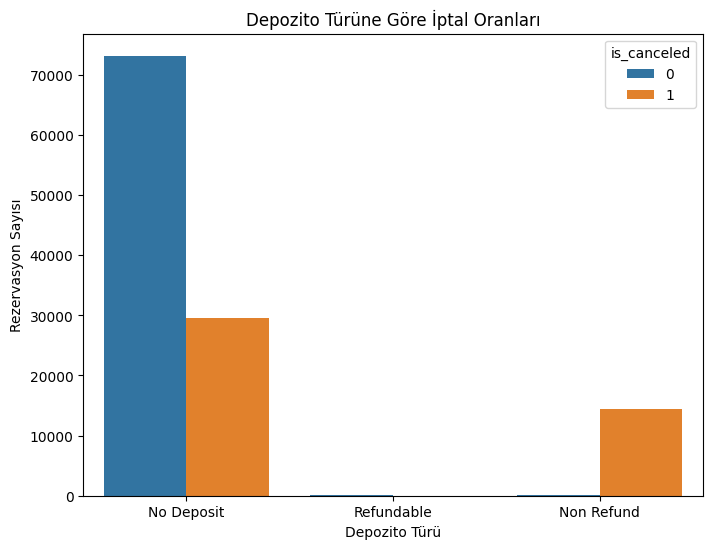

In [17]:
# Depozito Türünün Etkisi
plt.figure(figsize=(8, 6))
sns.countplot(x='deposit_type', hue='is_canceled', data=df)
plt.title('Depozito Türüne Göre İptal Oranları')
plt.xlabel('Depozito Türü')
plt.ylabel('Rezervasyon Sayısı')
plt.show()

----

Özellik Mühendisliği (Feature Engineering)

In [18]:
# Toplam gece konaklama sayısı
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# Toplam misafir sayısı
df['total_guests'] = df['adults'] + df['children'] + df['babies']

# Rezerve edilen oda ile atanan oda aynı mı?
df['is_room_assigned_same'] = (df['reserved_room_type'] == df['assigned_room_type']).astype(int)

print("\nÖzellik Mühendisliği Sonrası İlk 5 Satır:")
print(df[['total_nights', 'total_guests', 'is_room_assigned_same']].head())


Özellik Mühendisliği Sonrası İlk 5 Satır:
   total_nights  total_guests  is_room_assigned_same
2             1           1.0                      0
3             1           1.0                      1
4             2           2.0                      1
5             2           2.0                      1
6             2           2.0                      1



--- Lojistik Regresyon Model Sonuçları ---
              precision    recall  f1-score   support

           0       0.82      0.91      0.87     18347
           1       0.82      0.68      0.74     11003

    accuracy                           0.82     29350
   macro avg       0.82      0.79      0.80     29350
weighted avg       0.82      0.82      0.82     29350

ROC AUC Skoru: 0.9022

--- Random Forest Model Sonuçları ---
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     18347
           1       0.89      0.81      0.85     11003

    accuracy                           0.89     29350
   macro avg       0.89      0.87      0.88     29350
weighted avg       0.89      0.89      0.89     29350

ROC AUC Skoru: 0.9588


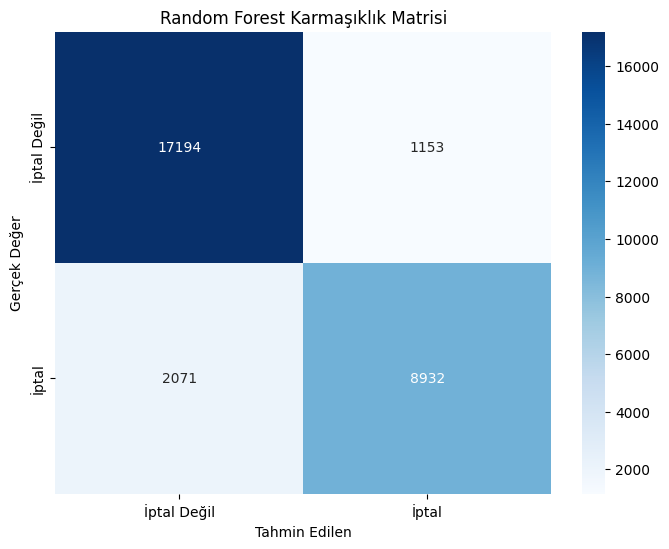

In [19]:
# 3.1 Modelleme için Veri Hazırlığı

# Gereksiz ve hedef değişkenle doğrudan ilişkili sütunları kaldıralım
# 'reservation_status' iptal durumunu zaten içerir, bu yüzden modelde olmamalı.
# 'reservation_status_date' ve tarih sütunlarını da şimdilik çıkarıyoruz.
df_model = df.drop([
    'reservation_status', 'reservation_status_date', 'arrival_date_year',
    'arrival_date_week_number', 'arrival_date_day_of_month', 'reserved_room_type', 'assigned_room_type'
], axis=1)


# Kategorik ve nümerik sütunları belirleme
categorical_features = df_model.select_dtypes(include=['object', 'category']).columns
numerical_features = df_model.select_dtypes(include=np.number).columns

# 'is_canceled' hedef değişken olduğu için nümerik özelliklerden çıkaralım
numerical_features = numerical_features.drop('is_canceled')

# Hedef değişken (y) ve özellikler (X)
X = df_model.drop('is_canceled', axis=1)
y = df_model['is_canceled']


# 3.2 Preprocessing Pipeline Oluşturma
# Bu pipeline, nümerik verileri standartlaştıracak ve kategorik verileri One-Hot-Encoding ile dönüştürecek.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Geriye kalan sütunları olduğu gibi bırakır
)


# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


# 4.1 Lojistik Regresyon Modeli
# Pipeline: Önce veri işleme, sonra model
log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

# Modeli eğitme
log_reg_pipeline.fit(X_train, y_train)

# Tahmin yapma
y_pred_lr = log_reg_pipeline.predict(X_test)

# Sonuçları Değerlendirme
print("\n--- Lojistik Regresyon Model Sonuçları ---")
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC Skoru: {roc_auc_score(y_test, log_reg_pipeline.predict_proba(X_test)[:, 1]):.4f}")


# 4.2 Random Forest Modeli
# Pipeline: Önce veri işleme, sonra model
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))])

# Modeli eğitme
rf_pipeline.fit(X_train, y_train)

# Tahmin yapma
y_pred_rf = rf_pipeline.predict(X_test)

# Sonuçları Değerlendirme
print("\n--- Random Forest Model Sonuçları ---")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Skoru: {roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1]):.4f}")

# Karmaşıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['İptal Değil', 'İptal'], yticklabels=['İptal Değil', 'İptal'])
plt.title('Random Forest Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.show()

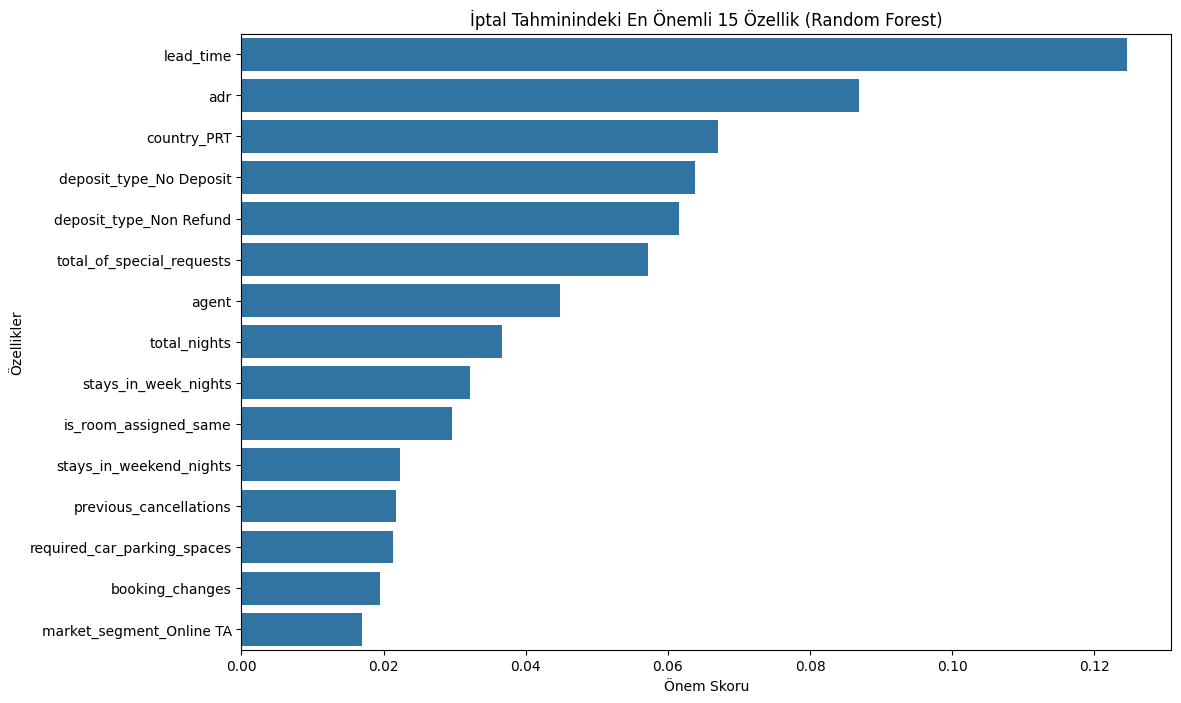

In [20]:
# 5.1 Modelin En Önemli Gördüğü Özellikler (Feature Importance)
# Pipeline'dan OneHotEncoder ile oluşturulan yeni sütun isimlerini alalım
ohe_feature_names = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, ohe_feature_names])

# Modelden özellik önem skorlarını alalım
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Önem skorlarını bir DataFrame'e dönüştürelim ve sıralayalım
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(15) # En önemli 15 özelliği alalım

# En önemli özellikleri görselleştirme
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('İptal Tahminindeki En Önemli 15 Özellik (Random Forest)')
plt.xlabel('Önem Skoru')
plt.ylabel('Özellikler')
plt.show()



# Genel 2

In [95]:
df = pd.read_csv("hotel_bookings 2.csv")

## EDA and Data Cleaning

In [96]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/7/2015


In [97]:
df.shape

(119390, 32)

In [98]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [101]:
df["reservation_status_date"] = pd.to_datetime(df['reservation_status_date'], format="%d/%m/%Y") #%Y-%m-%d

In [103]:
df["reservation_status_date"].head(15)

0    2015-07-01
1    2015-07-01
2    2015-07-02
3    2015-07-02
4    2015-07-03
5    2015-07-03
6    2015-07-03
7    2015-07-03
8    2015-05-06
9    2015-04-22
10   2015-06-23
11   2015-07-05
12   2015-07-05
13   2015-07-05
14   2015-07-05
Name: reservation_status_date, dtype: datetime64[ns]

In [105]:
df.describe(include= "object")

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166


In [106]:
for col in df.describe(include= "object").columns:
    print(col)
    print(df[col].unique())

hotel
['Resort Hotel' 'City Hotel']
arrival_date_month
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
meal
['BB' 'FB' 'HB' 'SC' 'Undefined']
country
['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IR

In [109]:
df.isnull().sum().sort_values(ascending=False)

company                           112593
agent                              16340
country                              488
children                               4
arrival_date_month                     0
arrival_date_week_number               0
hotel                                  0
is_canceled                            0
stays_in_weekend_nights                0
arrival_date_day_of_month              0
adults                                 0
stays_in_week_nights                   0
babies                                 0
meal                                   0
lead_time                              0
arrival_date_year                      0
distribution_channel                   0
market_segment                         0
previous_bookings_not_canceled         0
is_repeated_guest                      0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
previous_cancellations                 0
deposit_type    

In [110]:
df.drop(["company", "agent"], axis=1, inplace=True)
df.dropna(inplace=True)

In [111]:
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [112]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
count,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898
mean,0.371352,104.311435,2016.157656,27.166555,15.800880,0.928897,2.502145,1.858391,0.104207,0.007948,0.032011,0.087142,0.131634,0.221181,2.330754,102.003243,0.061885,0.571683,2016-07-30 07:37:53.336809984
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,2016-02-02 00:00:00
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,2016-08-08 00:00:00
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,2017-02-09 00:00:00
max,1.000000,737.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000,2017-09-14 00:00:00
std,0.483168,106.903309,0.707459,13.589971,8.780324,0.996216,1.900168,0.578576,0.399172,0.097380,0.176029,0.845869,1.484672,0.652785,17.630452,50.485862,0.244172,0.792678,NaN


In [114]:
df = df[df["adr"]<5000]

In [115]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
count,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897
mean,0.371347,104.312018,2016.157657,27.166674,15.800802,0.928905,2.502157,1.858390,0.104208,0.007948,0.032011,0.087143,0.131635,0.221175,2.330774,101.958683,0.061885,0.571688,2016-07-30 07:39:51.289939968
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,2016-02-02 00:00:00
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,2016-08-08 00:00:00
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,2017-02-09 00:00:00
max,1.000000,737.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,510.000000,8.000000,5.000000,2017-09-14 00:00:00
std,0.483167,106.903570,0.707462,13.589966,8.780321,0.996217,1.900171,0.578578,0.399174,0.097381,0.176030,0.845872,1.484678,0.652784,17.630525,48.091199,0.244173,0.792680,NaN


## Veri Analizi ve Görselleştirme

is_canceled
0    0.628653
1    0.371347
Name: proportion, dtype: float64


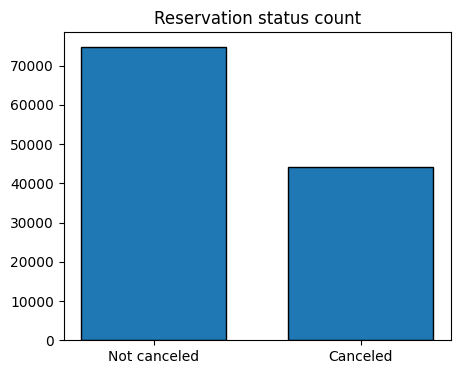

In [118]:
cancelled_perc = df["is_canceled"].value_counts(normalize = True)
print(cancelled_perc)

plt.figure(figsize = (5,4))
plt.title("Reservation status count")
plt.bar(["Not canceled", "Canceled"], df["is_canceled"].value_counts(), edgecolor = "k", width = 0.7)
plt.show()

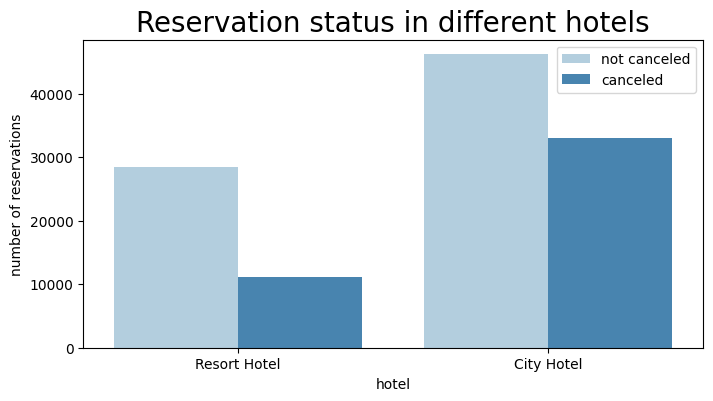

In [121]:
plt.figure(figsize = (8,4))
ax1 = sns.countplot(x = "hotel", hue = "is_canceled", data = df, palette = "Blues")
legends_labels, _ = ax1.get_legend_handles_labels()
ax1.legend(bbox_to_anchor = (1,1))
plt.title("Reservation status in different hotels", size = 20)
plt.xlabel("hotel")
plt.ylabel("number of reservations")
plt.legend(["not canceled", "canceled"])
plt.show()

In [122]:
resort_hotel = df[df["hotel"] == "Resort Hotel"]
resort_hotel["is_canceled"].value_counts(normalize = True)

is_canceled
0    0.72025
1    0.27975
Name: proportion, dtype: float64

In [123]:
city_hotel = df[df["hotel"] == "City Hotel"]
city_hotel["is_canceled"].value_counts(normalize = True)

is_canceled
0    0.582918
1    0.417082
Name: proportion, dtype: float64

In [124]:
resort_hotel = resort_hotel.groupby("reservation_status_date")[["adr"]].mean()
city_hotel = city_hotel.groupby("reservation_status_date")[["adr"]].mean()

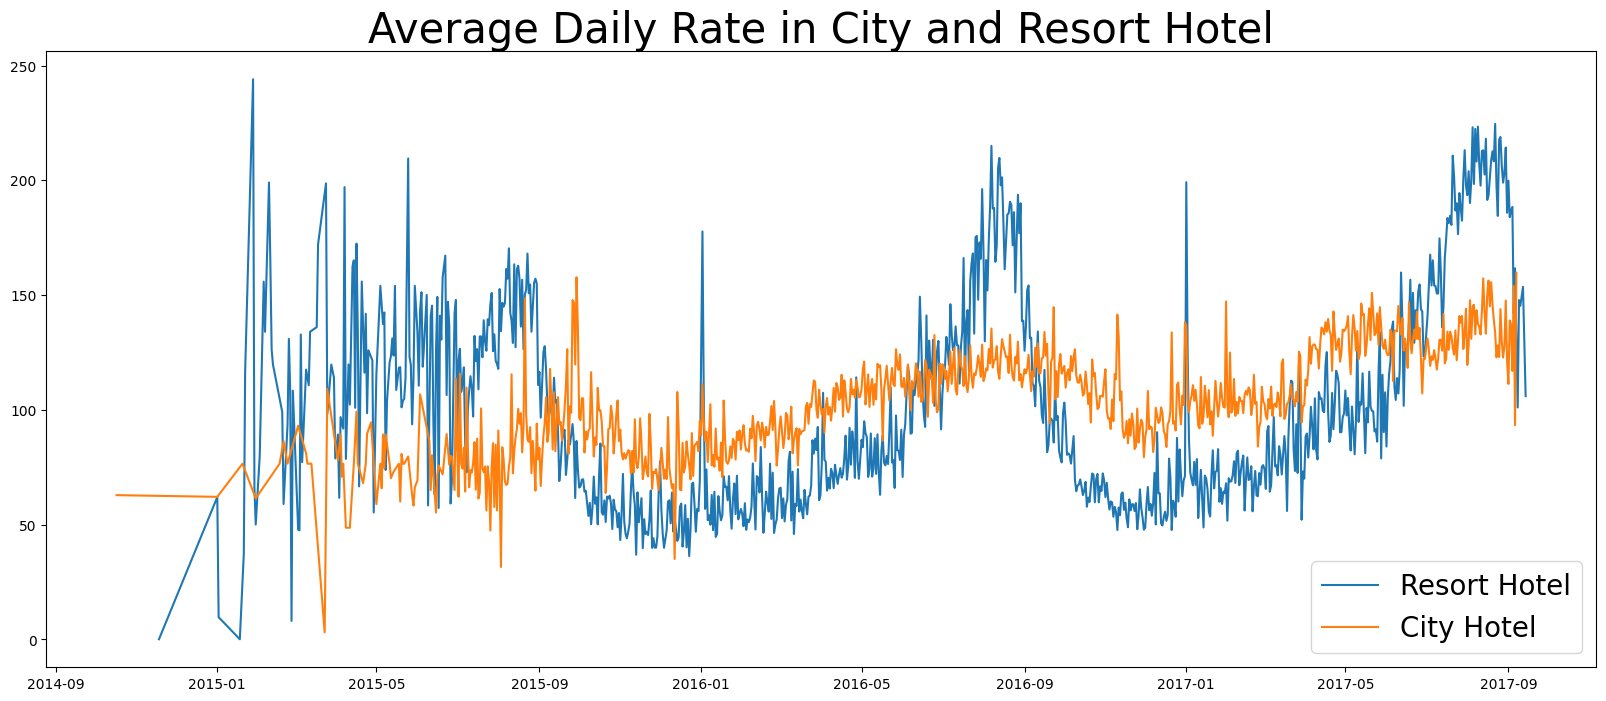

In [125]:
plt.figure(figsize = (20,8))
plt.title("Average Daily Rate in City and Resort Hotel", fontsize = 30)
plt.plot(resort_hotel.index, resort_hotel["adr"], label = "Resort Hotel")
plt.plot(city_hotel.index, city_hotel["adr"], label = "City Hotel")
plt.legend(fontsize = 20)
plt.show()

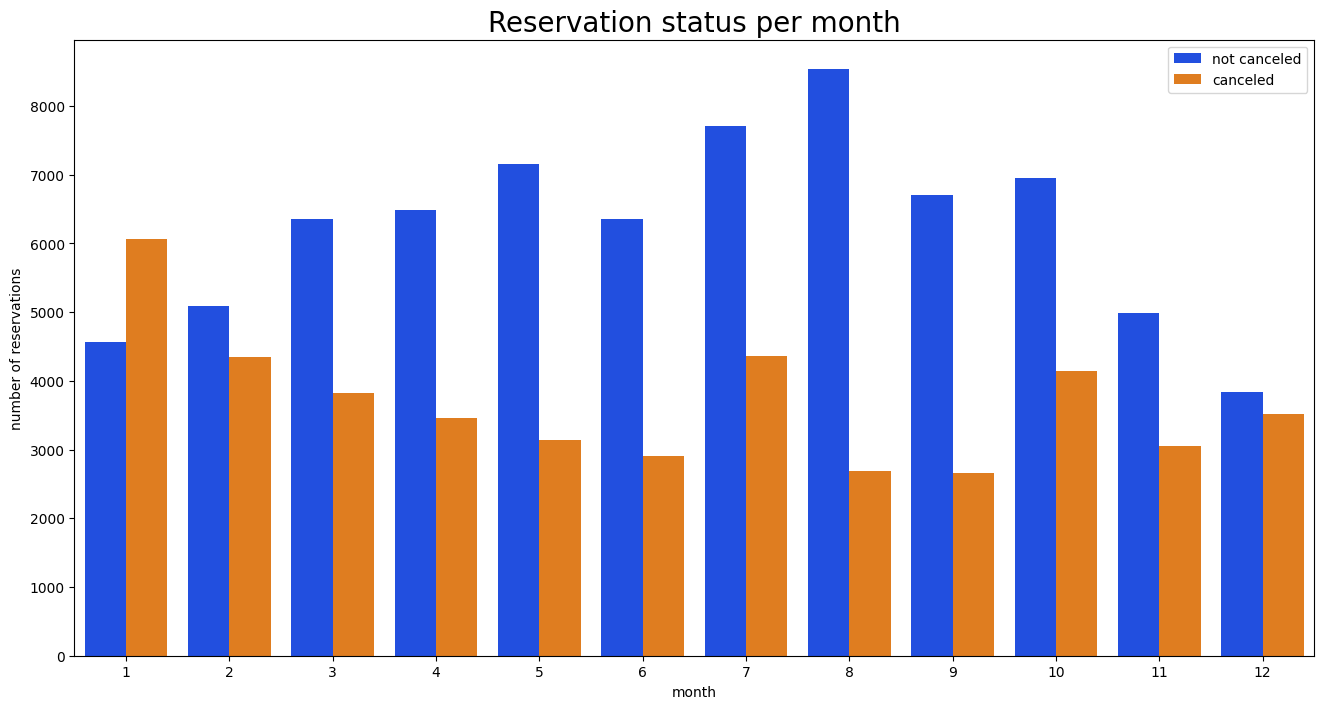

In [126]:
df["month"] = df["reservation_status_date"].dt.month
plt.figure(figsize = (16,8))
ax1 = sns.countplot(x = "month", hue = "is_canceled", data = df, palette = "bright")
legends_labels, _ = ax1.get_legend_handles_labels()
ax1.legend(bbox_to_anchor = (1,1))
plt.title("Reservation status per month", size = 20)
plt.xlabel("month")
plt.ylabel("number of reservations")
plt.legend(["not canceled", "canceled"])
plt.show()

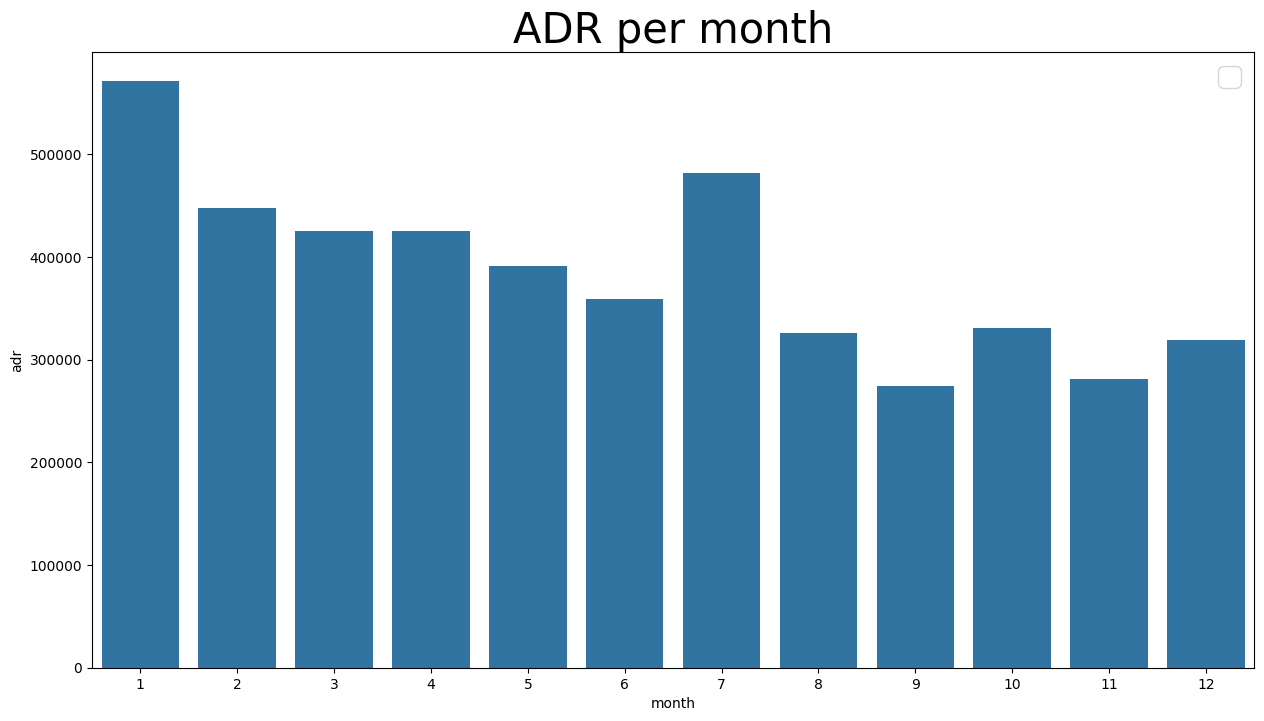

In [131]:
plt.figure(figsize = (15,8))
plt.title("ADR per month", fontsize = 30)
#sns.barplot("month", "adr", data = df[df["is_canceled"] == 1].groupby("month")[["adr"]].sum().reset_index())
df_grouped = df[df["is_canceled"] == 1].groupby("month")[["adr"]].sum().reset_index()
sns.barplot(x ="month", y="adr", data = df_grouped)
plt.legend(fontsize = 20)
plt.show()

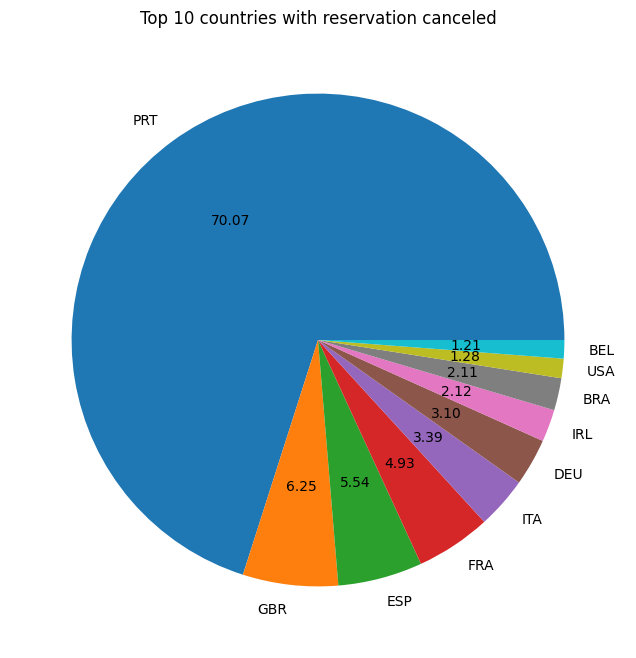

In [132]:
cancelled_data = df[df["is_canceled"] == 1]
top_10_country = cancelled_data["country"].value_counts()[:10]
plt.figure(figsize = (8,8))
plt.title("Top 10 countries with reservation canceled")
plt.pie(top_10_country, autopct = "%.2f", labels = top_10_country.index)
plt.show()

In [133]:
df["market_segment"].value_counts()

market_segment
Online TA        56402
Offline TA/TO    24159
Groups           19806
Direct           12448
Corporate         5111
Complementary      734
Aviation           237
Name: count, dtype: int64

In [134]:
df["market_segment"].value_counts(normalize = True)

market_segment
Online TA        0.474377
Offline TA/TO    0.203193
Groups           0.166581
Direct           0.104696
Corporate        0.042987
Complementary    0.006173
Aviation         0.001993
Name: proportion, dtype: float64

In [135]:
cancelled_data["market_segment"].value_counts(normalize = True)

market_segment
Online TA        0.469696
Groups           0.273985
Offline TA/TO    0.187466
Direct           0.043486
Corporate        0.022151
Complementary    0.002038
Aviation         0.001178
Name: proportion, dtype: float64

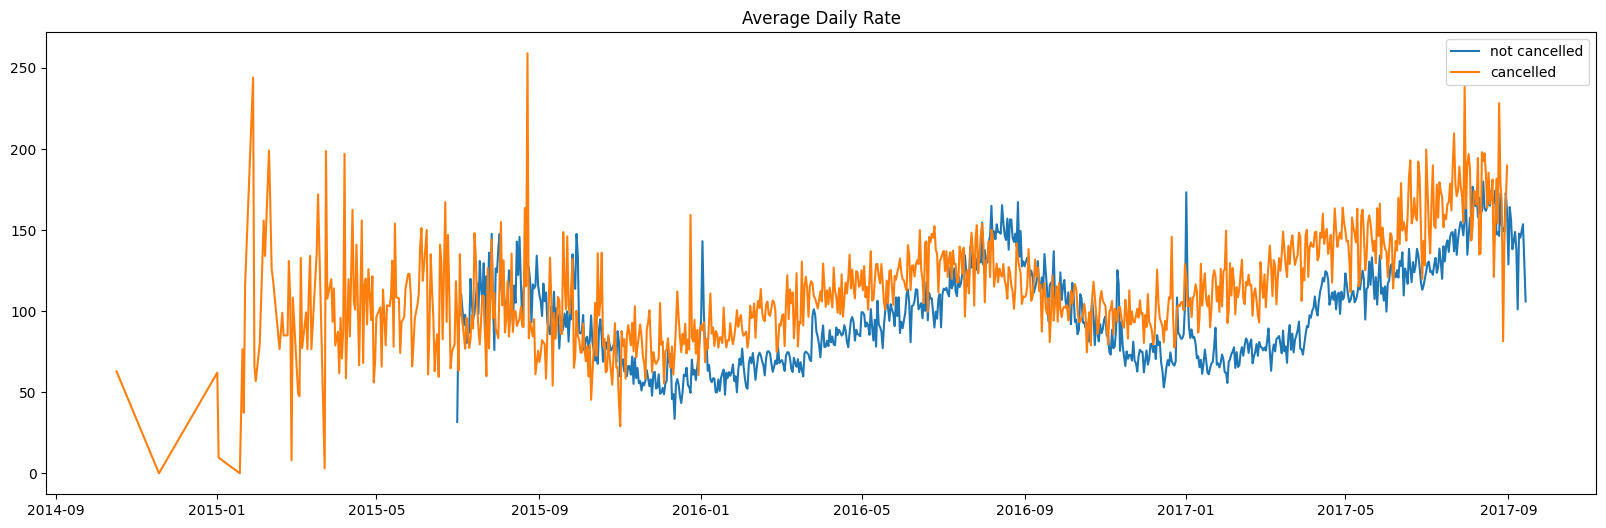

In [137]:
cancelled_df_adr = cancelled_data.groupby("reservation_status_date")[["adr"]].mean()
cancelled_df_adr.reset_index(inplace = True)
cancelled_df_adr.sort_values("reservation_status_date", inplace = True)

not_cancelled_data = df[df["is_canceled"] == 0]
not_cancelled_df_adr = not_cancelled_data.groupby("reservation_status_date")[["adr"]].mean()
not_cancelled_df_adr.reset_index(inplace = True)
not_cancelled_df_adr.sort_values("reservation_status_date", inplace = True)

plt.figure(figsize = (20,6))
plt.title("Average Daily Rate")
plt.plot(not_cancelled_df_adr["reservation_status_date"], not_cancelled_df_adr["adr"], label = "not cancelled")
plt.plot(cancelled_df_adr["reservation_status_date"], cancelled_df_adr["adr"], label = "cancelled")
plt.legend()

In [139]:
canceleld_df_adr = cancelled_df_adr[(cancelled_df_adr["reservation_status_date"]>"2016") & (cancelled_df_adr["reservation_status_date"]<"2017/09")]
not_cancelled_df_adr = not_cancelled_df_adr[(not_cancelled_df_adr["reservation_status_date"]>"2016") & (not_cancelled_df_adr["reservation_status_date"]< "2017/09")]

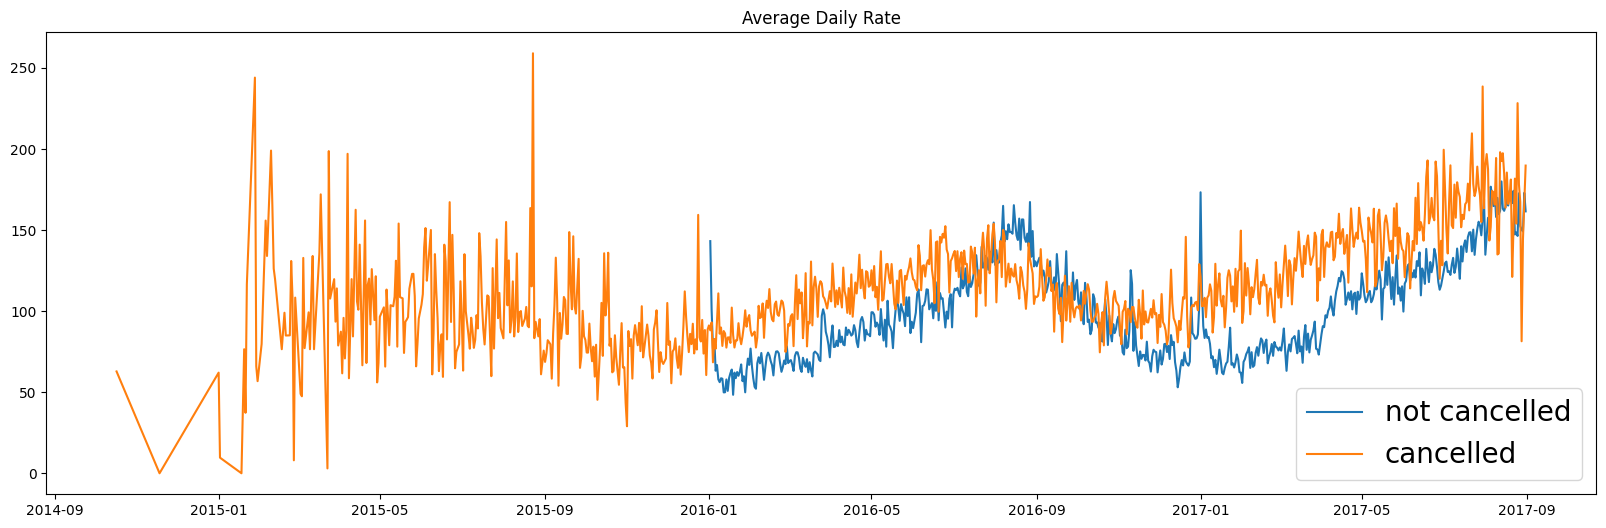

In [140]:
plt.figure(figsize = (20,6))
plt.title("Average Daily Rate")
plt.plot(not_cancelled_df_adr["reservation_status_date"], not_cancelled_df_adr["adr"], label = "not cancelled")
plt.plot(cancelled_df_adr["reservation_status_date"], cancelled_df_adr["adr"], label = "cancelled")
plt.legend(fontsize = 20)
plt.show()